[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/jotabruno/CLIMATE_CHANGE_CMIP6/blob/main/1GCM_CMIP6_INDICES_CLIMATICOS.ipynb
)


In [1]:
# Librerias requeridas para instalar, usamos pip 
#!pip install intake intake-esm
#!pip install xmip
#!pip install matplotlib
#!pip install aiohttp requests
#!pip install Cartopy
#!pip install icclim

In [13]:
import intake
import matplotlib.pyplot as plt
import xmip
from xmip.preprocessing import combined_preprocessing
import gcsfs
import numpy as np
import random
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import icclim 

import xarray as xr


In [10]:
import xclim.core.calendar as xcal


In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(cat_url)

In [4]:
# Filtramos el catálogo para una variable, tabla, experimento y modelo específicos
cat8 = cat.search(
    variable_id = 'pr',        # precipitacion  
    table_id = 'day',          # datos mensuales 
    experiment_id = 'historical',  
    source_id = ['MPI-ESM1-2-HR','MRI-ESM2-0','CESM2-WACCM','ACCESS-CM2','CMCC-ESM2',
                 'MPI-ESM1-2-LR','MIROC6','CanESM5'],      # modelo

    member_id = ['r1i1p1f1'],      # miembro
    grid_label = 'gn'
)
# Mostramos el DataFrame resultante con los metadatos filtrados
# 2. Abrir todos los modelos 
# ==============================
ds_dict_full_historical_pr = cat8.to_dataset_dict(
    zarr_kwargs={"consolidated": True}
)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
# Filtramos el catálogo para una variable, tabla, experimento y modelo específicos
cat6 = cat.search(
    variable_id = 'pr',        # precipitacion  
    table_id = 'day',          # datos mensuales 
    experiment_id = 'ssp585',  # simulación ssp585
    source_id = ['MPI-ESM1-2-HR','MRI-ESM2-0','CESM2-WACCM','ACCESS-CM2','CMCC-ESM2',
                 'MPI-ESM1-2-LR','MIROC6','CanESM5'], 
    member_id = ['r1i1p1f1'],      # miembro
    grid_label = 'gn'
)
# Mostramos el DataFrame resultante con los metadatos filtrados
# 2. Abrir todos los modelos 
# ==============================
ds_dict_full_ssp585_pr = cat6.to_dataset_dict(
    zarr_kwargs={"consolidated": True}
)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


C:\Users\jotabruno\anaconda3\envs\cmip6\lib\site-packages\intake_esm\source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
C:\Users\jotabruno\anaconda3\envs\cmip6\lib\site-packages\intake_esm\source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
C:\Users\jotabruno\anaconda3\envs\cmip6\lib\site-packages\intake_esm\source.py:99: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects inste

In [11]:
# =========================================================
# (1) PARCHE por compatibilidad xclim/icclim (si aplica)
# =========================================================
try:
    import xclim.core.calendar as xcal
    if not hasattr(xcal, "convert_calendar"):
        def convert_calendar(source, target, align_on=None, missing=None, dim="time"):
            return source.convert_calendar(calendar=target, dim=dim, align_on=align_on, missing=missing)
        xcal.convert_calendar = convert_calendar
except Exception:
    pass

# =========================================================
# CONFIG
# =========================================================
country = "Peru"
pad_deg = 1.5

t0_hist, t1_hist = "1981-01-01", "2014-12-31"
t0_fut,  t1_fut  = "2036-01-01", "2065-12-31"

slice_modes = ["year", "DJF", "MAM", "JJA", "SON"]   # anual + estacional
proj = ccrs.PlateCarree()

# =========================================================
# UTILIDADES
# =========================================================
def extent_from_country(country_name, pad_deg=2.0, resolution="10m"):
    shp = shapereader.natural_earth(
        resolution=resolution, category="cultural", name="admin_0_countries"
    )
    geoms = [
        r.geometry for r in shapereader.Reader(shp).records()
        if r.attributes.get("ADMIN") == country_name
    ]
    if not geoms:
        raise ValueError(f"No encontré el país: {country_name}")

    minx = min(g.bounds[0] for g in geoms)
    miny = min(g.bounds[1] for g in geoms)
    maxx = max(g.bounds[2] for g in geoms)
    maxy = max(g.bounds[3] for g in geoms)
    extent = (minx - pad_deg, maxx + pad_deg, miny - pad_deg, maxy + pad_deg)
    return extent, geoms

def to_model_dict(ds_dict):
    out = {}
    for _, ds in ds_dict.items():
        m = ds.attrs.get("source_id", None)
        if m is not None:
            out[m] = ds
    return out

def sel_time_safe_da(da, t0, t1):
    da = da.sortby("time")
    try:
        da = da.sel(time=slice(t0, t1))
    except Exception:
        y0, y1 = int(t0[:4]), int(t1[:4])
        da = da.where((da["time"].dt.year >= y0) & (da["time"].dt.year <= y1), drop=True)
    return da

def prep_pr_da(ds, extent, t0, t1):
    """
    - time slice
    - lon 0–360 -> -180–180
    - crop a país
    - pr: kg m-2 s-1 -> mm/day (icclim)
    """
    pr = ds["pr"].squeeze()

    if "time" in pr.dims:
        pr = sel_time_safe_da(pr, t0, t1)
        if pr.sizes.get("time", 0) == 0:
            return None

    # 0–360 -> -180–180
    if pr.lon.max() > 180:
        pr = pr.assign_coords(lon=((pr.lon + 180) % 360) - 180).sortby("lon")

    lon_min, lon_max, lat_min, lat_max = extent
    pr = pr.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    if pr.sizes.get("lon", 0) == 0 or pr.sizes.get("lat", 0) == 0:
        return None

    # kg m-2 s-1 == mm/s  -> mm/day
    pr = pr * 86400.0
    pr.attrs = dict(pr.attrs)
    pr.attrs["units"] = "mm/day"
    pr.name = "pr"

    return pr

def icclim_to_da(out):
    if isinstance(out, xr.Dataset):
        v = list(out.data_vars)[0]
        return out[v]
    return out

def compute_cdd_map(pr_da, slice_mode):
    out = icclim.index(
        in_files=pr_da,
        var_name="pr",
        index_name="CDD",
        slice_mode=slice_mode,
        ignore_Feb29th=True,
        logs_verbosity="LOW",
    )
    da = icclim_to_da(out)

    # promedio climatológico del periodo (sobre el tiempo de salida del índice)
    if "time" in da.dims and da.sizes.get("time", 0) > 0:
        da = da.mean("time", skipna=True)

    return da

def global_vmin_vmax(maps):
    vals = []
    for da in maps.values():
        if da is None:
            continue
        try:
            vals.append(float(da.min(skipna=True).values))
            vals.append(float(da.max(skipna=True).values))
        except Exception:
            x = da.load()
            vals.append(float(np.nanmin(x.values)))
            vals.append(float(np.nanmax(x.values)))
    if not vals:
        return None, None
    return float(np.nanmin(vals)), float(np.nanmax(vals))

def plot_maps(maps_by_model, models, extent, country_geoms, title, out_png, cmap="viridis"):
    # 2x4 (8 modelos); si tienes más, cambia el layout
    fig, axes = plt.subplots(2, 4, figsize=(22, 10), subplot_kw={"projection": proj})
    axes = axes.flatten()

    vmin, vmax = global_vmin_vmax(maps_by_model)
    im = None

    for ax, m in zip(axes, models[:8]):
        ax.set_extent(extent, crs=proj)

        da = maps_by_model.get(m)
        if da is None:
            ax.set_title(f"{m}\n(sin datos)", fontsize=10)
            ax.add_geometries(country_geoms, crs=proj, facecolor="none",
                              edgecolor="black", linewidth=1.2, zorder=3)
            ax.coastlines(resolution="110m", linewidth=0.8)
            continue

        im = ax.pcolormesh(
            da["lon"], da["lat"], da,
            shading="auto",
            cmap=cmap,
            vmin=vmin, vmax=vmax,
            transform=proj
        )
        ax.coastlines(resolution="110m", linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_geometries(country_geoms, crs=proj, facecolor="none",
                          edgecolor="black", linewidth=1.2, zorder=3)
        ax.set_title(m, fontsize=10)

    for ax in axes[len(models[:8]):]:
        ax.axis("off")

    fig.subplots_adjust(left=0.05, right=0.98, top=0.90, bottom=0.14, wspace=0.15, hspace=0.25)

    cax = fig.add_axes([0.25, 0.07, 0.5, 0.03])
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label("CDD (días)")

    fig.suptitle(title, fontsize=15)
    fig.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()

2025-12-21 13:41:24,540 --- icclim 7.0.4
2025-12-21 13:41:24,541 --- BEGIN EXECUTION
2025-12-21 13:41:24,542 Processing: 0%


Modelos comunes: ['ACCESS-CM2', 'CESM2-WACCM', 'CMCC-ESM2', 'CanESM5', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0']


2025-12-21 13:41:25,092 Processing: 100%
2025-12-21 13:41:25,093 --- icclim 7.0.4
2025-12-21 13:41:25,094 --- CPU SECS = 97.844    
2025-12-21 13:41:25,094 --- END EXECUTION
2025-12-21 13:41:25,193 --- icclim 7.0.4
2025-12-21 13:41:25,194 --- BEGIN EXECUTION
2025-12-21 13:41:25,194 Processing: 0%
2025-12-21 13:41:25,699 Processing: 100%
2025-12-21 13:41:25,700 --- icclim 7.0.4
2025-12-21 13:41:25,701 --- CPU SECS = 98.453    
2025-12-21 13:41:25,702 --- END EXECUTION
2025-12-21 13:41:25,803 --- icclim 7.0.4
2025-12-21 13:41:25,804 --- BEGIN EXECUTION
2025-12-21 13:41:25,804 Processing: 0%
2025-12-21 13:41:26,590 Processing: 100%
2025-12-21 13:41:26,591 --- icclim 7.0.4
2025-12-21 13:41:26,592 --- CPU SECS = 99.328    
2025-12-21 13:41:26,592 --- END EXECUTION
2025-12-21 13:41:26,697 --- icclim 7.0.4
2025-12-21 13:41:26,698 --- BEGIN EXECUTION
2025-12-21 13:41:26,698 Processing: 0%
2025-12-21 13:41:27,212 Processing: 100%
2025-12-21 13:41:27,213 --- icclim 7.0.4
2025-12-21 13:41:27,214 

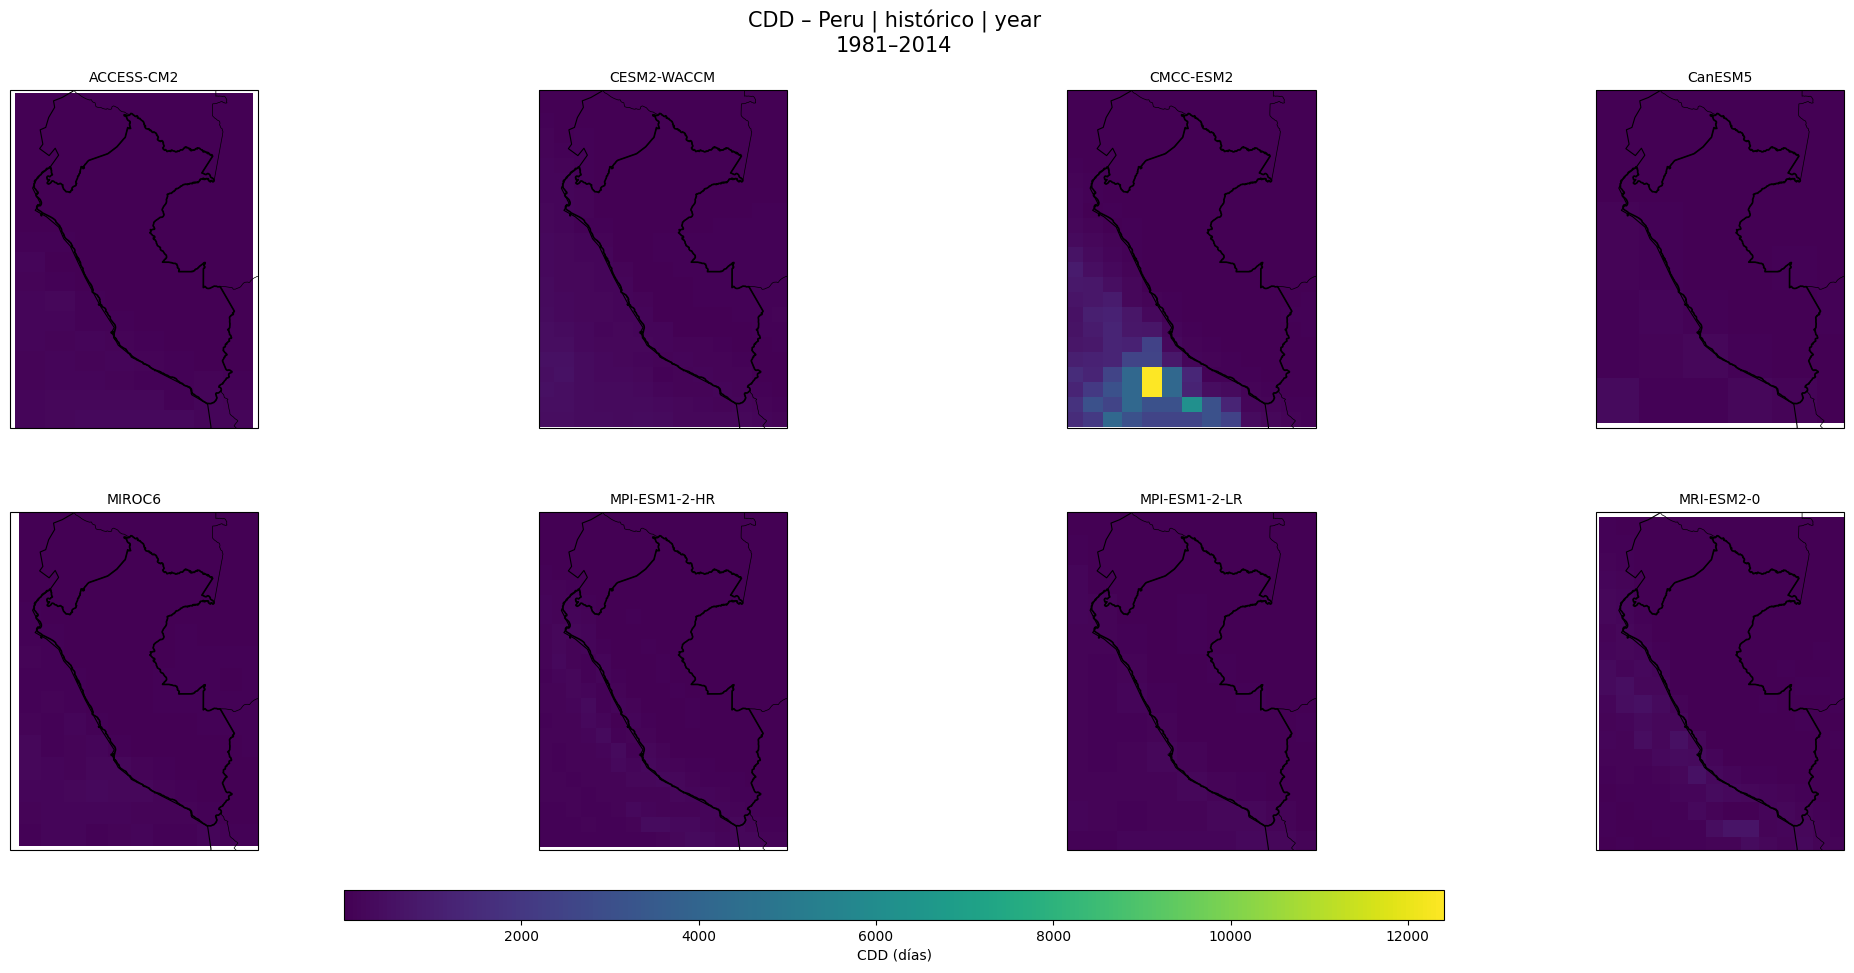

2025-12-21 14:08:46,592 --- icclim 7.0.4
2025-12-21 14:08:46,593 --- BEGIN EXECUTION
2025-12-21 14:08:46,594 Processing: 0%
2025-12-21 14:08:47,350 Processing: 100%
2025-12-21 14:08:47,352 --- icclim 7.0.4
2025-12-21 14:08:47,352 --- CPU SECS = 1753.969  
2025-12-21 14:08:47,353 --- END EXECUTION
2025-12-21 14:08:47,415 --- icclim 7.0.4
2025-12-21 14:08:47,416 --- BEGIN EXECUTION
2025-12-21 14:08:47,417 Processing: 0%
2025-12-21 14:08:47,876 Processing: 100%
2025-12-21 14:08:47,878 --- icclim 7.0.4
2025-12-21 14:08:47,878 --- CPU SECS = 1754.500  
2025-12-21 14:08:47,879 --- END EXECUTION
2025-12-21 14:08:47,980 --- icclim 7.0.4
2025-12-21 14:08:47,981 --- BEGIN EXECUTION
2025-12-21 14:08:47,982 Processing: 0%
2025-12-21 14:08:48,441 Processing: 100%
2025-12-21 14:08:48,443 --- icclim 7.0.4
2025-12-21 14:08:48,443 --- CPU SECS = 1755.047  
2025-12-21 14:08:48,444 --- END EXECUTION
2025-12-21 14:08:48,462 --- icclim 7.0.4
2025-12-21 14:08:48,463 --- BEGIN EXECUTION
2025-12-21 14:08:48,4

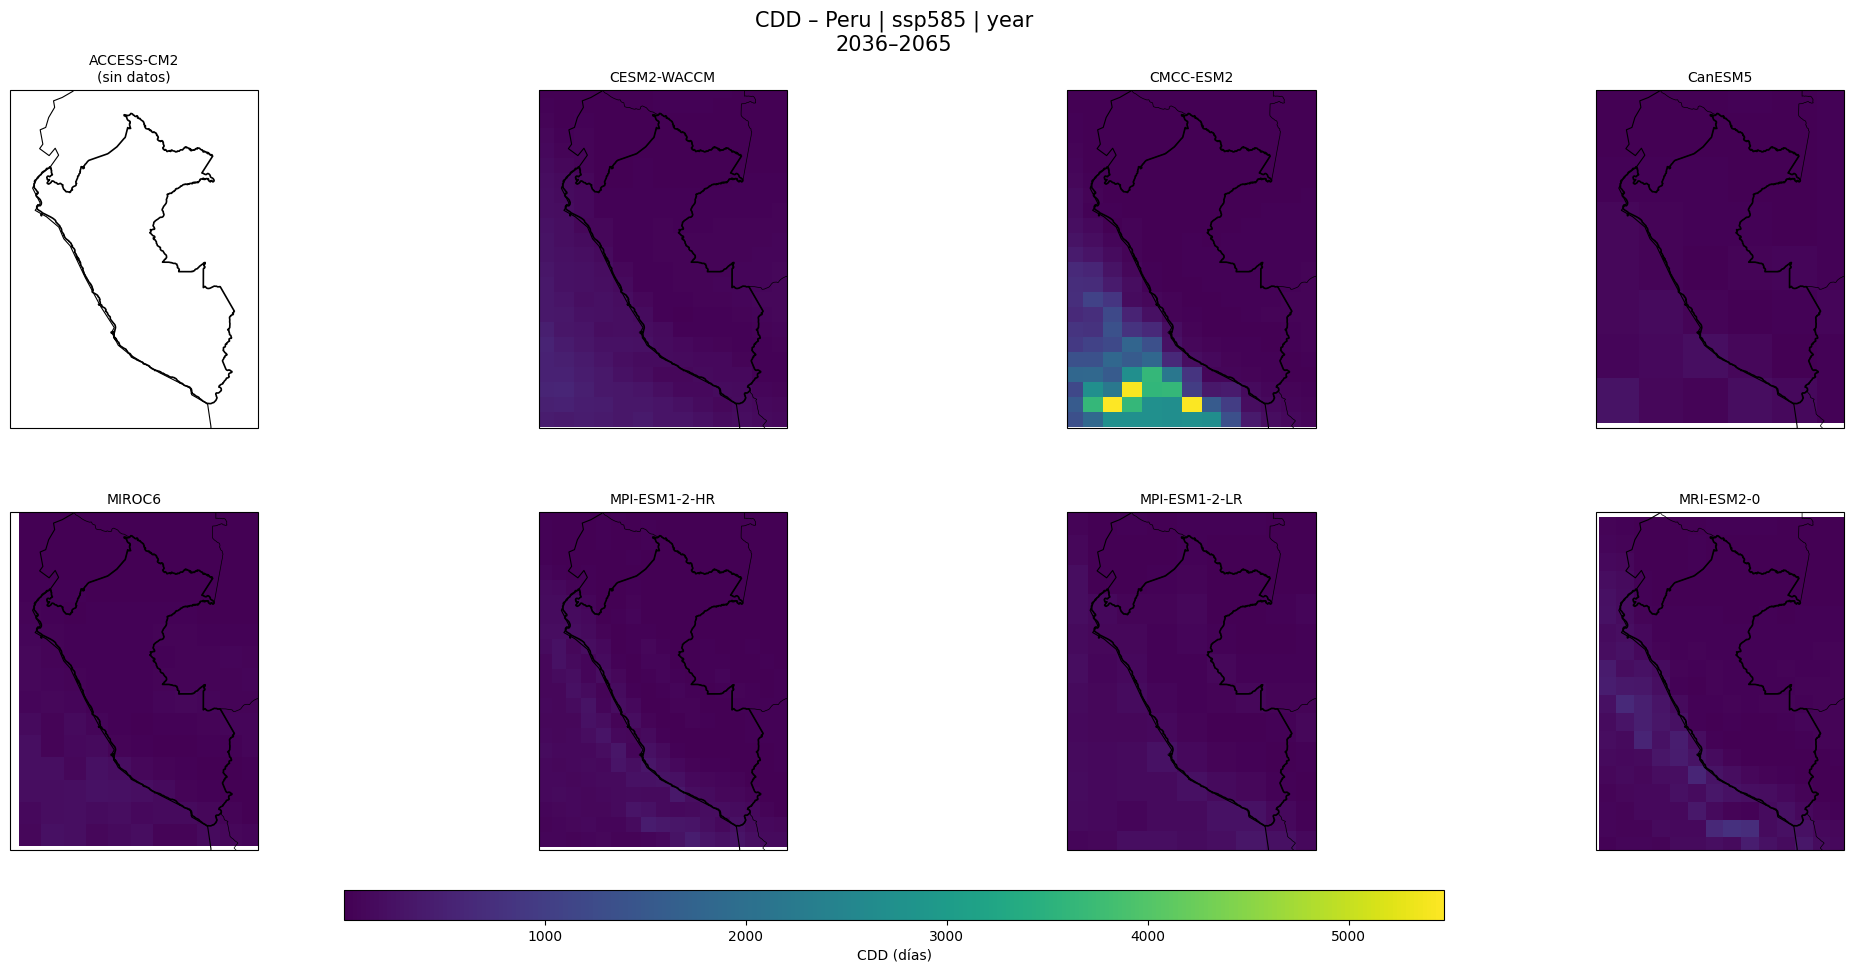

2025-12-21 14:36:06,485 --- icclim 7.0.4
2025-12-21 14:36:06,486 --- BEGIN EXECUTION
2025-12-21 14:36:06,487 Processing: 0%
C:\Users\jotabruno\anaconda3\envs\cmip6\lib\site-packages\xclim\core\units.py:704: UserWarning: Unable to find the sampling frequency of the data along dimension time. Assuming 'D' instead.
  m, freq_u_raw = infer_sampling_units(orig, deffreq=deffreq, dim=dim)
2025-12-21 14:36:07,391 Processing: 100%
2025-12-21 14:36:07,392 --- icclim 7.0.4
2025-12-21 14:36:07,393 --- CPU SECS = 3409.047  
2025-12-21 14:36:07,394 --- END EXECUTION
2025-12-21 14:36:07,497 --- icclim 7.0.4
2025-12-21 14:36:07,498 --- BEGIN EXECUTION
2025-12-21 14:36:07,498 Processing: 0%
C:\Users\jotabruno\anaconda3\envs\cmip6\lib\site-packages\xclim\core\units.py:704: UserWarning: Unable to find the sampling frequency of the data along dimension time. Assuming 'D' instead.
  m, freq_u_raw = infer_sampling_units(orig, deffreq=deffreq, dim=dim)
2025-12-21 14:36:08,048 Processing: 100%
2025-12-21 14:3

In [ ]:
# =========================================================
# EXTENT PERÚ + MODELOS DISPONIBLES
# (asume que ya existen):
#   ds_dict_full_historical_pr
#   ds_dict_full_ssp585_pr
# =========================================================
extent, country_geoms = extent_from_country(country, pad_deg=pad_deg, resolution="10m")

hist_by_model = to_model_dict(ds_dict_full_historical_pr)
fut_by_model  = to_model_dict(ds_dict_full_ssp585_pr)

models = sorted(set(hist_by_model.keys()).intersection(set(fut_by_model.keys())))
print("Modelos comunes:", models)

# =========================================================
# (2) PLOT HISTÓRICO y FUTURO, SIN CAMBIOS (CDD)
# =========================================================
for sm in slice_modes:

    # -------- HISTÓRICO
    maps_hist = {}
    for m in models:
        pr_da = prep_pr_da(hist_by_model[m], extent, t0_hist, t1_hist)
        if pr_da is None:
            maps_hist[m] = None
            continue
        try:
            maps_hist[m] = compute_cdd_map(pr_da, sm)
        except Exception as e:
            print(f"[HIST|CDD|{sm}] {m} ERROR: {repr(e)}")
            maps_hist[m] = None

    plot_maps(
        maps_hist, models, extent, country_geoms,
        title=f"CDD – {country} | histórico | {sm}\n{t0_hist[:4]}–{t1_hist[:4]}",
        out_png=f"CDD_{country}_historical_{sm}_{t0_hist[:4]}_{t1_hist[:4]}.png",
        cmap="viridis"
    )

    # -------- FUTURO (ssp585)
    maps_fut = {}
    for m in models:
        pr_da = prep_pr_da(fut_by_model[m], extent, t0_fut, t1_fut)
        if pr_da is None:
            maps_fut[m] = None
            continue
        try:
            maps_fut[m] = compute_cdd_map(pr_da, sm)
        except Exception as e:
            print(f"[FUT|CDD|{sm}] {m} ERROR: {repr(e)}")
            maps_fut[m] = None

    plot_maps(
        maps_fut, models, extent, country_geoms,
        title=f"CDD – {country} | ssp585 | {sm}\n{t0_fut[:4]}–{t1_fut[:4]}",
        out_png=f"CDD_{country}_ssp585_{sm}_{t0_fut[:4]}_{t1_fut[:4]}.png",
        cmap="viridis"
    )